In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import importlib.util
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage as snd
from matplotlib.colors import ListedColormap
from matplotlib import cm

In [2]:
def analyze_data(input_filename):
    print("analyze_data")
    # Load data
    data = np.load(input_filename)

    # Watershed: Identify separate pores
    distance = snd.distance_transform_edt((data == 0))
    local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3, 3)), labels=(data == 0))
    markers = snd.label(local_maxi)[0]
    labels = watershed(-distance, markers, mask=(data == 0))

    # Pore color map
    somecmap = cm.get_cmap('magma', 256)
    cvals = np.random.uniform(0, 1, len(np.unique(labels)))
    newcmp = ListedColormap(somecmap(cvals))

    # Plot statistics: pore radii
    volumes = np.array([np.sum(labels == label) for label in np.unique(labels)])
    volumes.sort()
    # Ignore two largest labels (background and matrix)
    radii = (volumes[:-2] * 3 / (4 * np.pi)) ** (1 / 3)  # Find radii, assuming spherical pores
    _ = plt.hist(radii, bins=200)

    # Save plot
    filename_without_npy = input_filename.split(os.path.sep)[-1].split('.')[0]
    filename_save = filename_without_npy + '_statistics.png'
    output_filedir = "test_job_output"  # specify your output directory here

    os.makedirs(output_filedir, exist_ok=True)
    plt.savefig(os.path.join(output_filedir, filename_save))

In [3]:
def check_porosity(input_filename):
    input_filename = input_filename
    output_filedir_accepted = 'foam_ct_data_accepted'
    output_filedir_discarded = 'foam_ct_data_discarded'
    porosity_lower_threshold = 0.8
    utils_path = '../idmc_utils_module.py'

    # Load the custom utils module
    spec = importlib.util.spec_from_file_location("utils", utils_path)
    utils = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(utils)

    # Parameters
    n_samples = 10000

    # Load data
    ct_data = np.load(input_filename)

    # Plot center slices
    utils.plot_center_slices(ct_data)

    # Perform GMM fitting on samples from the dataset
    sample_inds = np.random.randint(0, len(ct_data.ravel()), n_samples)
    n_components = 2
    means, stds, weights = utils.perform_GMM_np(
        ct_data.ravel()[sample_inds],
        n_components,
        plot=True,
        title='GMM fitted to ' + str(n_samples) + ' of ' +
        str(len(ct_data.ravel())) + ' datapoints')
    print('weights:', weights)

    # Classify data as 'accepted' or 'discarded' according to porosity level
    filename_without_npy = input_filename.split(os.path.sep)[-1].split('.')[0]

    if np.max(weights) > porosity_lower_threshold:
        os.makedirs(output_filedir_accepted, exist_ok=True)
        acc_path = os.path.join(output_filedir_accepted, filename_without_npy + '.txt')
        with open(acc_path, 'w') as file:
            file.write(str(np.max(weights)) + ' ' + str(np.min(weights)))
    else:
        os.makedirs(output_filedir_discarded, exist_ok=True)
        dis_path = os.path.join(output_filedir_discarded, filename_without_npy + '.txt')
        with open(dis_path, 'w') as file:
            file.write(str(np.max(weights)) + ' ' + str(np.min(weights)))

analyze_data


<ipython-input-2-a084c0a12c3a>:8: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3, 3)), labels=(data == 0))


/home/ibli/.local/lib/python3.10/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
<ipython-input-2-a084c0a12c3a>:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  somecmap = cm.get_cmap('magma', 256)


/home/ibli/Documents/GitHub/meowBa/tests/timingTest/generated_notebooks/../idmc_utils_module.py:73: RuntimeWarning: divide by zero encountered in divide
  gaussian = lambda x, mu, s, A: A*np.exp(-0.5*(x-mu)**2/s**2)/np.sqrt(2*np.pi*s**2)
/home/ibli/Documents/GitHub/meowBa/tests/timingTest/generated_notebooks/../idmc_utils_module.py:73: RuntimeWarning: invalid value encountered in divide
  gaussian = lambda x, mu, s, A: A*np.exp(-0.5*(x-mu)**2/s**2)/np.sqrt(2*np.pi*s**2)


weights: [0.8505, 0.1495]


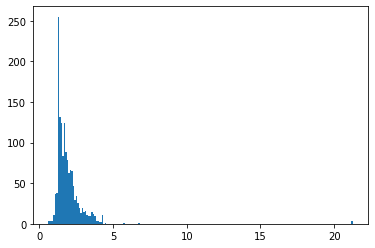

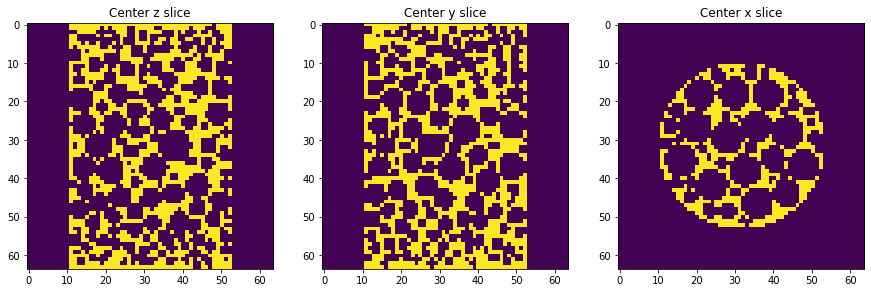

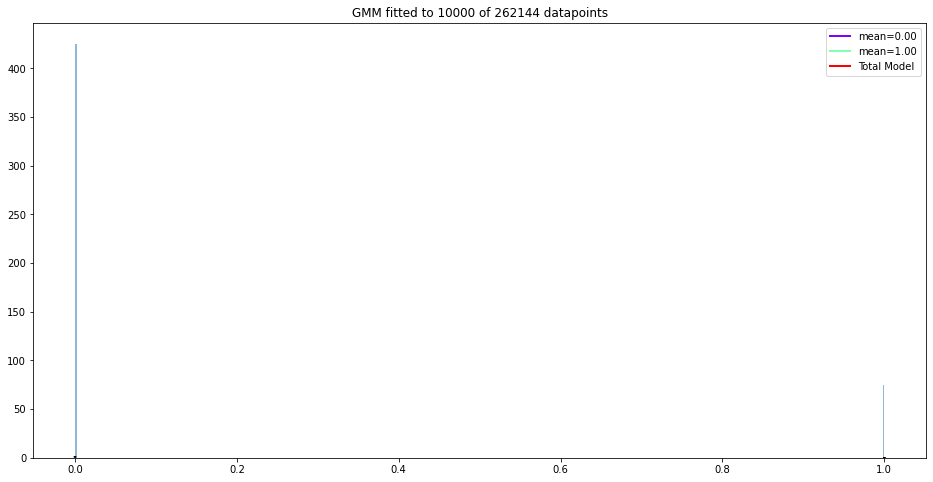

In [4]:
analyze_data('../test_data/foam_ct_data/foam_dataset_6_1000_64_64_64.npy') 
check_porosity('../test_data/foam_ct_data/foam_dataset_6_1000_64_64_64.npy')